In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
from itertools import combinations
from mip import Model, OptimizationStatus, maximize, xsum, BINARY
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Section 1: Data preparation

This section calculates the properties of items that will be used for optimal test assembly. These include:

- Item response functions: expected probability of correct response conditioned on ability
- Item information function: expected reliability of item conditioned on ability

In [2]:
from scipy.stats import norm

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
stan_model = '3pl_m2'

## Define ability range (TIF).
pts = np.linspace(-1,1,5)

## Define ability range (IRF).
theta = np.linspace(-3,3,1001)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define item parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load StanFit.
params = read_csv(os.path.join('stan_results', f'{stan_model}_summary.tsv'), sep='\t', index_col=0)

## Extract parameters.
beta  = params.T.filter(regex='beta\[').T['Mean'].values
alpha = params.T.filter(regex='alpha\[').T['Mean'].values
gamma = 0.25

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define item functioning.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

def inv_logit(x):
    return 1 / (1 + np.exp(-x))

## Compute p(correct).
mu = np.outer(theta, alpha) - beta
p = gamma + (1-gamma) * inv_logit(mu)

## Weight by distribution of abilities. 
prior = norm(0,1).pdf(theta)
IRF = (prior @ p) / prior.sum()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define item information.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute p(correct).
mu = np.outer(alpha, pts) - beta.reshape(-1,1)
p = gamma + (1-gamma) * inv_logit(mu)

## Compute information.
IIF = np.square(alpha.reshape(-1,1)) * ((1-p) / p) * np.square((p - gamma) / (1 - gamma))

## Section 2: Ultra-short forms

This section of code perform optimal test assembly under the following constraints:

- Assemble 3 parallel test forms of 12 items (i.e. ultra-short forms)
- Test information is to be maximized (under standard normal distribution of ability) 
- Test form reliability must be $\rho \geq 0.7$
- Item clones in each test form must belong to the same template family
- Differences in test information between test forms is to be minimized 

### 2.1 Optimal test assembly

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define number of forms.
n_form = 3

## Define test length.
n_item = 12

## Define TIF difference tolerance.
dtol = 5e-2

## Define difficulty tolerance.
ptol = 1.0

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Test assembly.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define item triplets (i.e. item IDs of 3 clones per template & distractor type).
triples = []
for i in range(0, len(alpha), 3):
    triple = list(range(i,i+3))
    for j in range(3): triples.append(np.roll(triple, j).tolist())
n_triples = len(triples) 

## Initialize model.
model = Model("assembly")

## Initialize binary variables.
x = [model.add_var(var_type=BINARY) for i in range(n_triples)]

## Define model objective: maximize TIF.
model.objective = maximize(xsum(x[i] * IIF[ix].sum() for i, ix in enumerate(triples)))

## Constraint #1: maximum number of triples.
## Specification: sum of binary item weights per form must equal user-specified 
##                number of test items.
model += xsum(x[i] for i in range(n_triples)) == n_item

## Constraint #2: one triplet per item family.
## Specification: sum of binary item weights, per item family (6 clones),
##                must be equal to or less than one.
for i in range(0, n_triples, 6): 
    model += xsum(x[i:i+6]) <= 1
    
## Constraint #3: minimize TIF differences.
## Specification: minimize difference of TIF, per ability level, across
##                each unique pair of test forms.
for k in range(IIF.shape[1]):
    model += xsum(x[i] * IIF[j,k] for i, (j,_,_) in enumerate(triples)) -\
             xsum(x[i] * IIF[j,k] for i, (_,j,_) in enumerate(triples)) <= dtol
    model += xsum(x[i] * IIF[j,k] for i, (_,j,_) in enumerate(triples)) -\
             xsum(x[i] * IIF[j,k] for i, (j,_,_) in enumerate(triples)) <= dtol
    model += xsum(x[i] * IIF[j,k] for i, (j,_,_) in enumerate(triples)) -\
             xsum(x[i] * IIF[j,k] for i, (_,_,j) in enumerate(triples)) <= dtol
    model += xsum(x[i] * IIF[j,k] for i, (_,_,j) in enumerate(triples)) -\
             xsum(x[i] * IIF[j,k] for i, (j,_,_) in enumerate(triples)) <= dtol
    
## Constraint #4: set lower bound on form difficulty.
## Specification: the expected test response function cannot exceed 
##                a user-specified value.
model += xsum(x[i] * IRF[j] for i, (j,_,_) in enumerate(triples)) / n_item <= ptol
model += xsum(x[i] * IRF[j] for i, (_,j,_) in enumerate(triples)) / n_item <= ptol
model += xsum(x[i] * IRF[j] for i, (_,_,j) in enumerate(triples)) / n_item <= ptol
    
## Perform optimization.
status = model.optimize(max_seconds=300)
print('optimal solution: %s' %(status == OptimizationStatus.OPTIMAL))

## Extract selected item triplets.
selected = [i for i in range(n_triples) if x[i].x]

## Construct test forms (zero-indexed).
items = np.array([triples[i] for i in selected]).T
print(items)

optimal solution: True
[[ 52  95 125 130 149 189 245 252 291 304 334 358]
 [ 53  93 123 131 147 190 243 253 292 305 335 359]
 [ 51  94 124 129 148 191 244 254 293 303 333 357]]


### 2.2 Test information

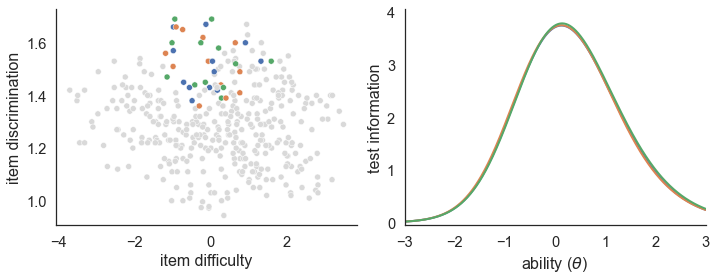

In [4]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(10,4))
palette = ['0.85', '#4c72b0', '#dd8452', '#55a868']

## Define form indicators.
hue = np.zeros_like(alpha)

## Iteratively plot test form information.
for i, ix in enumerate(items):
    
    ## Define indicators.
    hue[ix] = i+1
    
    ## Compute p(correct).
    theta = np.linspace(-3,3,1001)
    mu = np.outer(theta, alpha[ix]) - beta[ix]
    p = gamma + (1-gamma) * inv_logit(mu)
    
    ## Compute information.
    I = np.square(alpha[ix]) * ((1-p) / p) * np.square((p - gamma) / (1 - gamma))
    
    ## Plot test information.
    axes[1].plot(theta, I.sum(axis=1), lw=2)

## Add detail.
axes[1].set(xlim=(theta.min(), theta.max()), xlabel=r'ability ($\theta$)', 
            ylim=(-0.05, 4.05), ylabel='test information')

## Plot test form indicators.
sns.scatterplot(x=beta, y=alpha, hue=hue, palette=palette, legend=False, ax=axes[0])
axes[0].set(xlabel='item difficulty', ylabel='item discrimination')

sns.despine()
plt.tight_layout()

### 2.3 Item functioning

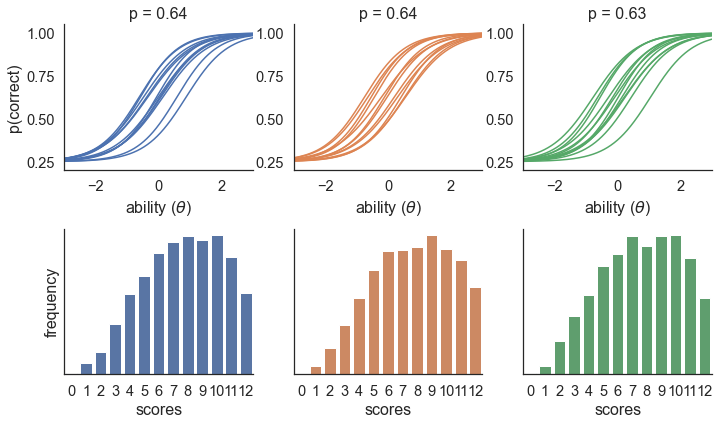

In [5]:
## Initialize canvas.
fig, axes = plt.subplots(2,3,figsize=(10,6))
palette = ['#4c72b0', '#dd8452', '#55a868']

## Iteratively plot.
np.random.seed(47404)
for i, (ix, color) in enumerate(zip(items, palette)):
    
    ## Compute p(correct).
    theta = np.sort(np.random.normal(0,1,5000))
    mu = np.outer(theta, alpha[ix]) - beta[ix]
    p = gamma + (1-gamma) * inv_logit(mu)
    
    ## Simulate scores.
    scores = np.random.binomial(1,p).sum(axis=1)
    
    ## Plot item functioning.
    axes[0,i].plot(theta, p, color=color)    
    axes[0,i].set(xlim=(-3,3), xlabel=r'ability ($\theta$)', ylim=(0.2, 1.05), title='p = %0.2f' %p.mean())
    if not i: axes[0,i].set(ylabel='p(correct)')
    
    ## Plot score distribution.
    sns.countplot(x=scores, order=np.arange(13), color=color, ax=axes[1,i])
    axes[1,i].set(xlabel=r'scores', yticks=[], ylabel='')
    if not i: axes[1,i].set(ylabel='frequency')
    
sns.despine()
plt.tight_layout()

### 2.4 IRT test reliability

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define ability distribution.
theta = np.linspace(-3,3,1001)

## Define integration weights.
w = norm.pdf(theta)
w /= w.sum()

## Iterate over item sets.
for i, ix in enumerate(items):
    
    ## Compute p(correct).
    mu = np.outer(theta, alpha[ix]) - beta[ix]
    p = gamma + (1-gamma) * inv_logit(mu)

    ## Compute true score variance.
    sigma_t = w @ np.square(p.sum(axis=1) - w @ p.sum(axis=1))
    
    ## Compute item error variance.
    sigma_e = w @ np.sum(p * (1-p), axis=1)
    
    ## Compute reliability.
    rho = sigma_t / (sigma_t + sigma_e)
    
    print('Short form %s: %0.3f' %(i+1, rho))

Short form 1: 0.707
Short form 2: 0.708
Short form 3: 0.706


## Section 3: Long forms

This section of code perform optimal test assembly under the following constraints:

- Assemble 2 parallel test forms of 24 items (i.e. long forms)
- Test information is to be maximized (under standard normal distribution of ability) 
- Test form reliability must be $\rho \geq 0.8$
- Differences in test information between test forms is to be minimized 
- Test forms cannot exceed a lower bound on the expected level of difficulty

### 3.1 Optimal test assembly

In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define number of forms.
n_form = 2

## Define test length.
n_item = 24

## Define TIF tolerance.
dtol = 1e-1

## Define difficulty tolerance.
ptol = 0.6

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Test assembly.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define number of total items.
n_clone = beta.size

## Initialize model.
model = Model("assembly")

## Initialize binary variables.
x = [model.add_var(var_type=BINARY) for i in range(n_form * n_clone)]

## Define model objective.
model.objective = maximize(xsum(x[i] * IIF[i % n_clone].sum() for i in range(n_form * n_clone)))

## Constraint #1: maximum number of item clones per form.
## Specification: sum of binary item weights per form must equal user-specified 
##                number of test items.
for d in range(n_form):
    model += xsum(x[i] for i in range(d*n_clone,(d+1)*n_clone)) == n_item

## Constraint #2: clones belong to only one form.
## Specification: sum of binary item weights, across each set of weights
##                belonging to a clone, must be equal to or less than one.
for k in range(n_clone):
    model += xsum(x[j] for j in range(k, n_clone * n_form, n_clone)) <= 1
    
## Constraint #3: one clone per item template per form.
## Specification: sum of binary item weights, per item family (6 clones),
##                must be equal to or less than one.
for d in range(n_form):
    for k in range(d*n_clone, (d+1)*n_clone, 6): 
        model += xsum(x[k:k+6]) <= 1
    
## Constraint #4: minimize difference of TIF across forms.
## Specification: minimize difference of TIF, per ability level, across
##                each unique pair of test forms.
for k in range(len(pts)):
    for d1, d2 in combinations(list(range(n_form)), 2):
        model += xsum(x[i] * IIF[i % n_clone,k] for i in range(d1*n_clone, (d1+1)*n_clone)) -\
                 xsum(x[i] * IIF[i % n_clone,k] for i in range(d2*n_clone, (d2+1)*n_clone)) <= dtol
    
## Constraint #5: set lower bound on form difficulty.
## Specification: the expected test response function cannot exceed 
##                a user-specified value.
for d in range(n_form):
    model += xsum(x[i] * IRF[i % n_clone] for i in range(d*n_clone,(d+1)*n_clone)) / n_item <= ptol
    
## Perform optimization.
status = model.optimize(max_seconds=300)
print('optimal solution: %s' %(status == OptimizationStatus.OPTIMAL))

## Extract selected item clones (zero-indexed).
items = np.array([i % n_clone for i in range(n_form * n_clone) if x[i].x]).reshape(n_form,n_item)
print(items)

optimal solution: True
[[ 53  75  95 111 124 131 147 155 179 191 237 243 254 287 291 304 333 340
  347 352 357 369 377 382]
 [ 52  77  93 125 129 148 153 177 184 189 196 226 245 253 262 285 293 305
  334 345 353 358 371 381]]


### 3.2 Test information

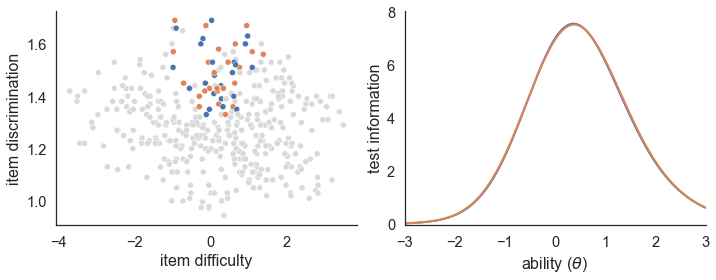

In [8]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(10,4))
palette = ['0.85', '#4c72b0', '#dd8452']

## Define form indicators.
hue = np.zeros_like(alpha)

## Iteratively plot test form information.
for i, ix in enumerate(items):
    
    ## Define indicators.
    hue[ix] = i+1
    
    ## Compute p(correct).
    theta = np.linspace(-3,3,1001)
    mu = np.outer(theta, alpha[ix]) - beta[ix]
    p = gamma + (1-gamma) * inv_logit(mu)
    
    ## Compute information.
    I = np.square(alpha[ix]) * ((1-p) / p) * np.square((p - gamma) / (1 - gamma))
    
    ## Plot test information.
    axes[1].plot(theta, I.sum(axis=1), lw=2)

## Add detail.
axes[1].set(xlim=(theta.min(), theta.max()), xlabel=r'ability ($\theta$)', 
            ylim=(-0.05, 8.05), ylabel='test information')

## Plot test form indicators.
sns.scatterplot(x=beta, y=alpha, hue=hue, palette=palette, legend=False, ax=axes[0])
axes[0].set(xlabel='item difficulty', ylabel='item discrimination')

sns.despine()
plt.tight_layout()

### 3.3 Item functioning

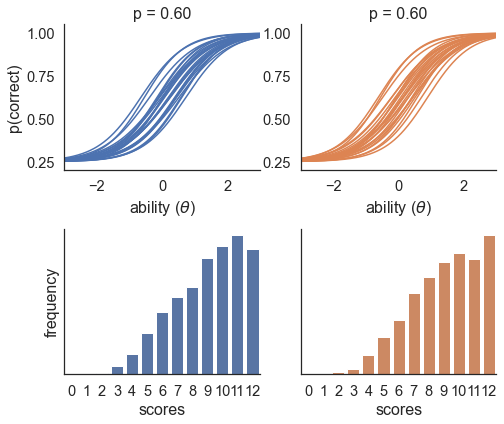

In [9]:
## Initialize canvas.
fig, axes = plt.subplots(2,2,figsize=(7,6))
palette = ['#4c72b0', '#dd8452']

## Iteratively plot.
np.random.seed(47404)
for i, (ix, color) in enumerate(zip(items, palette)):
    
    ## Compute p(correct).
    theta = np.sort(np.random.normal(0,1,5000))
    mu = np.outer(theta, alpha[ix]) - beta[ix]
    p = gamma + (1-gamma) * inv_logit(mu)
    
    ## Simulate scores.
    scores = np.random.binomial(1,p).sum(axis=1)
    
    ## Plot item functioning.
    axes[0,i].plot(theta, p, color=color)    
    axes[0,i].set(xlim=(-3,3), xlabel=r'ability ($\theta$)', ylim=(0.2, 1.05), title='p = %0.2f' %p.mean())
    if not i: axes[0,i].set(ylabel='p(correct)')
    
    ## Plot score distribution.
    sns.countplot(x=scores, order=np.arange(13), color=color, ax=axes[1,i])
    axes[1,i].set(xlabel=r'scores', yticks=[], ylabel='')
    if not i: axes[1,i].set(ylabel='frequency')
    
sns.despine()
plt.tight_layout()

### 3.4 IRT test reliability

In [10]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define ability distribution.
theta = np.linspace(-3,3,1001)

## Define integration weights.
w = norm.pdf(theta)
w /= w.sum()

## Iterate over item sets.
for i, ix in enumerate(items):
    
    ## Compute p(correct).
    mu = np.outer(theta, alpha[ix]) - beta[ix]
    p = gamma + (1-gamma) * inv_logit(mu)

    ## Compute true score variance.
    sigma_t = w @ np.square(p.sum(axis=1) - w @ p.sum(axis=1))
    
    ## Compute item error variance.
    sigma_e = w @ np.sum(p * (1-p), axis=1)
    
    ## Compute reliability.
    rho = sigma_t / (sigma_t + sigma_e)
    
    print('Short form %s: %0.3f' %(i+1, rho))

Short form 1: 0.821
Short form 2: 0.821


## Section 4: Figure / Tables

In [ ]:
import matplotlib.gridspec as gridspec
sns.set_theme('notebook', style='white', font='sans-serif', font_scale=1.33)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(12,4), constrained_layout=True)

## Initialize panels.
spec = fig.add_gridspec(1, 3, left=0.12, right=0.98, top=0.98, bottom=0.12, wspace=0.08, hspace=0)

## Define ability range.
theta = np.linspace(-4,4,5001)

## Define palette.
palette = sns.color_palette('Blues', n_colors=4).as_hex()[1:]

## Define annotation position.
xytext = (0.035, 1.00)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Panel A: selected items.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define hues.
hue = np.zeros_like(alpha)
for i, ix in enumerate(items): hue[ix] = i+1
    
## Initialize axis.
ax = plt.subplot(spec[0])

## Plot selected items.
sns.scatterplot(x=beta[hue==0], y=alpha[hue==0], color='0.85',  zorder=-1, ax=ax)
sns.scatterplot(x=beta[hue>=1], y=alpha[hue>=1], hue=hue[hue>=1], palette=palette, ax=ax)
ax.legend_.set_visible(False)

## Add detail.
ax.set(xlim=(-4.0,4.0), xlabel=r'Item difficulty ($\beta$)',
       ylim=(0.9,1.75), ylabel=r'Item discrimination ($\alpha$)')

## Update legend.
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, ['SF-1','SF-2','SF-3'], loc=1, frameon=True, handletextpad=0, borderpad=0.05)

## Add annotation.
ax.annotate('A', (0,0), xytext, xycoords='axes fraction', ha='left', va='top', 
            fontsize=24, fontweight='bold')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Panel B: test characteristic curves.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize axis.
ax = plt.subplot(spec[1])

for i, (ix, color) in enumerate(zip(items, palette)):
    
    ## Compute p(correct).
    mu = np.outer(theta, alpha[ix]) - beta[ix]
    p = gamma + (1-gamma) * inv_logit(mu)
    
    ## Plot test characteristic curves.
    ax.plot(theta, p.sum(axis=1), color=color, lw=2.5, alpha=0.8)

## Add details.
ax.set(xlim=(-4.0,4.0), xlabel=r'Ability level ($\theta$)',
       ylim=(1.5,12.5), ylabel=r'Total score')

## Add annotation.
ax.annotate('B', (0,0), xytext, xycoords='axes fraction', ha='left', va='top', 
            fontsize=24, fontweight='bold')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Panel C: test information functions.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize axis.
ax = plt.subplot(spec[2])

for i, (ix, color) in enumerate(zip(items, palette)):
    
    ## Compute p(correct).
    mu = np.outer(theta, alpha[ix]) - beta[ix]
    p = gamma + (1-gamma) * inv_logit(mu)
    
    ## Compute information.
    I = np.square(alpha[ix]) * ((1-p) / p) * np.square((p - gamma) / (1 - gamma))
    
    ## Plot test characteristic curves.
    ax.plot(theta, I.sum(axis=1), color=color, lw=2.5, alpha=0.8, label='SF-%s' %(i+1))

## Add details.
ax.set(xlim=(-4.0,4.0), xlabel=r'Ability level ($\theta$)',
       ylim=(-0.02,4.16), ylabel=r'Test information')

## Update legend.
ax.legend(loc=1, frameon=False, handlelength=1.25, handletextpad=0.5, borderpad=0.05)

## Add annotation.
ax.annotate('C', (0,0), xytext, xycoords='axes fraction', ha='left', va='top', 
            fontsize=24, fontweight='bold')

sns.despine()
plt.savefig(os.path.join('..', '05_Figures', 'fig02.png'), dpi=100)